<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/GDSTK_CPW_Feed_Coupled_to_Resonator%2BCross_Cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code is ran entirely in Google Colab and outputs a preview and GDS file. A coplanar waveguide geometry is used for the feedline and the resonator elements. Also, a cross capacitor is introduced. Although the Josephson Junctions are not drawn, they can be added by scripting their geometries using the GDSTK library or by drawing them in KLayout (open source layout software).

In [31]:
!pip install gdstk --quiet

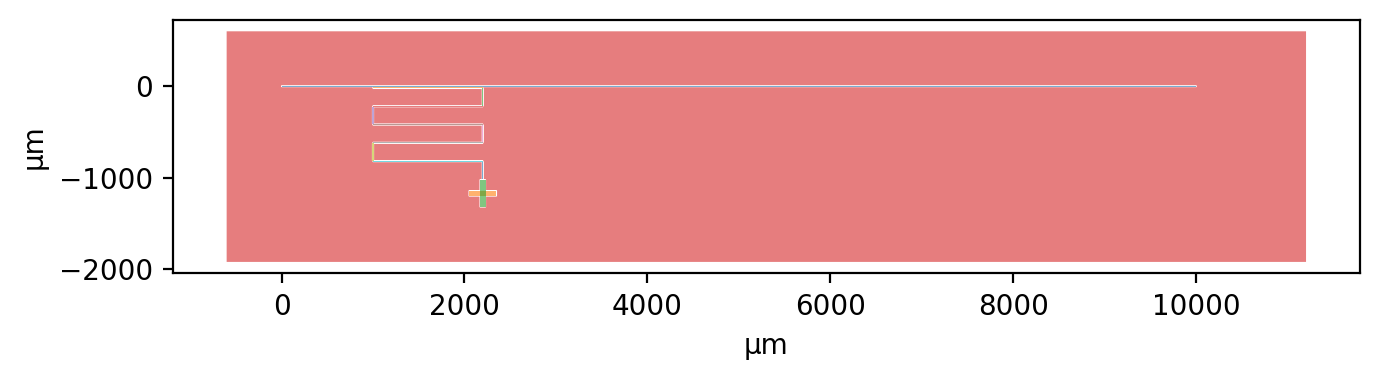

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
# =============================================================
# Google Colab Notebook — Planar CPW Feed‑Resonator–Transmon Layout (v1)
# =============================================================
# Author : Onri Jay Benally
# Date   : 2025‑06‑04
# -------------------------------------------------------------
# Run Cell 1 → 5 in order. Final cell writes `cpw_layout_v1.gds`.
# -------------------------------------------------------------
# Cell 1 — Setup & Imports (pin GDSTK for stable API)
# -------------------------------------------------------------
!pip -q install gdstk==0.9.41 matplotlib

import gdstk
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200  # crisp preview

# -------------------------------------------------------------
# Preview helper works whether Cell.plot exists or not
# -------------------------------------------------------------

def preview(cell, figsize=(7, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    if hasattr(cell, "plot"):
        cell.plot(ax)
    else:
        for poly in cell.polygons:
            pts = poly.points
            ax.fill(*zip(*pts), lw=0.3, alpha=0.6)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# Cell 2 — Technology / Geometry Parameters
# -------------------------------------------------------------
tech = dict(
    w_feed = 10.0,
    g_feed = 6.0,
    w_res  = 12.0,
    g_res  = 6.0,
    lambda_quarter = 6000.0,   # µm (≈ λ_g/4 at 5 GHz)
    n_meanders     = 5,
    elbow_radius   = 100.0,    # µm
    pad_length     = 300.0,
    pad_width      = 60.0,
    jj_overlap     = 2.0,
    d_feed_res     = 2.0,      # feed ↔ meander vertical gap
    d_res_qb       = 2.0,      # meander ↔ qubit vertical gap
    margin         = 600.0,    # chip frame margin
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # for ground clearance

# -------------------------------------------------------------
# Cell 3 — Builder helpers
# -------------------------------------------------------------

def build_straight_cpw(origin, length, width):
    x0, y0   = origin
    w        = width
    return [gdstk.rectangle((x0, y0 - w/2), (x0 + length, y0 + w/2))]


def build_meander(origin, p):
    x0, y0   = origin
    seg      = p['lambda_quarter'] / p['n_meanders']
    w        = p['w_res']
    r        = p['elbow_radius']

    poly      = []
    direction = 1
    cx, cy    = x0, y0
    for _ in range(p['n_meanders']):
        # horizontal section
        poly.append(gdstk.rectangle((cx, cy - w/2), (cx + direction*seg, cy + w/2)))
        cx += direction * seg
        # vertical drop to next row
        poly.append(gdstk.rectangle((cx - w/2, cy - w/2), (cx + w/2, cy - (2*r - w/2))))
        cy -= 2 * r
        direction *= -1
    # Return polygons **and** bottom‑left corner of last horizontal (for qubit placement)
    bottom_x = cx  # after horizontal segment
    bottom_y = cy  # already moved down by last leg
    return poly, (bottom_x, bottom_y)


def build_cross_qubit(center, p):
    cx, cy = center
    L, W   = p['pad_length'], p['pad_width']
    return [
        gdstk.rectangle((cx - L/2, cy - W/2), (cx + L/2, cy + W/2)),
        gdstk.rectangle((cx - W/2, cy - L/2), (cx + W/2, cy + L/2)),
    ]

# -------------------------------------------------------------
# Cell 4 — Chip assembly & ground carving
# -------------------------------------------------------------

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")

    conductors = []

    # ---------------- Feedline (top) ----------------
    feed_len = 10000.0
    feed     = build_straight_cpw((0.0, 0.0), feed_len, p['w_feed'])
    cell.add(*feed)
    conductors.extend(feed)

    # ---------------- Meander (middle) -------------
    res_origin = (
        1000.0,  # 1 mm in x
        -(p['w_feed']/2 + p['g_feed'] + p['d_feed_res'] + p['w_res']/2),
    )
    meander_polys, meander_end = build_meander(res_origin, p)
    cell.add(*meander_polys)
    conductors.extend(meander_polys)

    # ---------------- Cross qubit (bottom) ---------
    # Centre directly under bottom end of meander
    seg = p['lambda_quarter'] / p['n_meanders']
    bottom_x = res_origin[0] + seg  # derived analytically for odd n_meanders
    bottom_y = res_origin[1] - p['n_meanders'] * 2 * p['elbow_radius']

    qb_center = (
        bottom_x,
        bottom_y - p['d_res_qb'] - p['pad_length']/2,
    )
    cross = build_cross_qubit(qb_center, p)
    cell.add(*cross)
    conductors.extend(cross)

    # ---------------- Ground plane -----------------
    conductor_union = gdstk.boolean(conductors, [], "or")
    clearance       = p['g_max'] + 0.1
    keepout         = gdstk.offset(conductor_union, clearance, join="round")

    chip_w = feed_len + 2 * p['margin']
    chip_h_pos = p['margin']
    chip_h_neg = abs(qb_center[1]) + p['pad_length']/2 + p['margin']
    full_ground = gdstk.rectangle((-p['margin'], -chip_h_neg), (chip_w, chip_h_pos))

    ground = gdstk.boolean(full_ground, keepout, "not")
    cell.add(*ground)

    return lib

# -------------------------------------------------------------
# Cell 5 — Preview & GDS export
# -------------------------------------------------------------
lib = build_full_chip(tech)
preview(lib.top_level()[0])

lib.write_gds("cpw_layout_v1.gds")
try:
    from google.colab import files
    files.download("cpw_layout_v1.gds")
except ModuleNotFoundError:
    print("Running locally – GDS saved to working directory.")

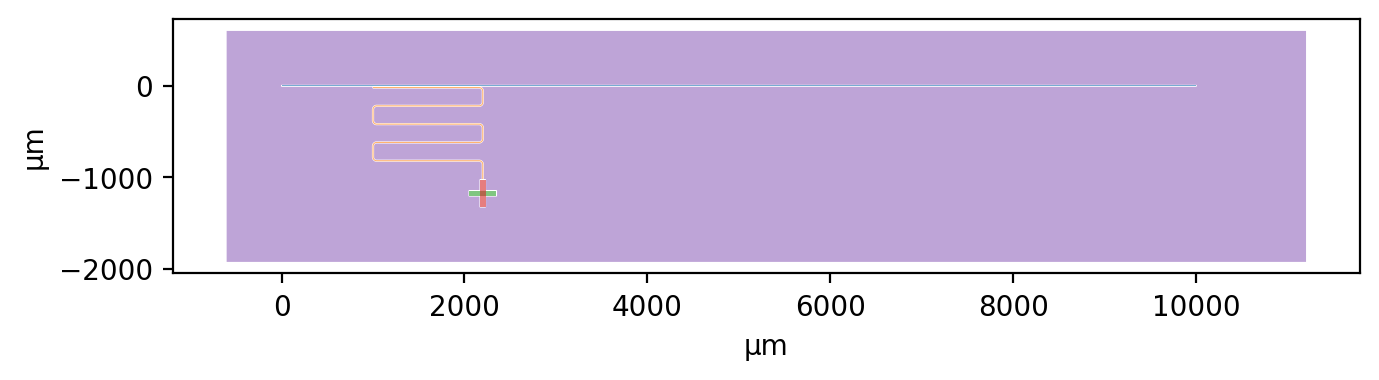

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# =============================================================
# Google Colab Notebook — Planar CPW Feed‑Resonator–Transmon Layout (v2)
# =============================================================
# Author : Onri Jay Benally — cross capacitor shifted
# Date   : 2025‑06‑04
# -------------------------------------------------------------
# Run Cell 1 → 5 in order. Final cell writes `cpw_layout_v2.gds`.
# -------------------------------------------------------------
# Cell 1 — Setup & Imports (pin GDSTK for stable API)
# -------------------------------------------------------------
!pip -q install gdstk==0.9.41 matplotlib

import gdstk
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200  # crisp preview

# -------------------------------------------------------------
# Preview helper works whether Cell.plot exists or not
# -------------------------------------------------------------

def preview(cell, figsize=(7, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    if hasattr(cell, "plot"):
        cell.plot(ax)
    else:
        for poly in cell.polygons:
            pts = poly.points
            ax.fill(*zip(*pts), lw=0.3, alpha=0.6)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# Cell 2 — Technology / Geometry Parameters
# -------------------------------------------------------------
tech = dict(
    w_feed = 10.0,
    g_feed = 6.0,
    w_res  = 12.0,
    g_res  = 6.0,
    lambda_quarter = 6000.0,   # µm (≈ λ_g/4 at 5 GHz)
    n_meanders     = 5,
    elbow_radius   = 100.0,    # µm
    fillet         = 40.0,     # µm bend radius for FlexPath
    pad_length     = 300.0,
    pad_width      = 60.0,
    jj_overlap     = 2.0,
    d_feed_res     = 2.0,      # feed ↔ meander vertical gap
    d_res_qb       = 2.0,      # meander ↔ qubit vertical gap (before extra shift)
    margin         = 600.0,    # chip frame margin
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # for ground clearance

# -------------------------------------------------------------
# Cell 3 — Builder helpers
# -------------------------------------------------------------

def build_straight_cpw(origin, length, width):
    x0, y0   = origin
    w        = width
    return [gdstk.rectangle((x0, y0 - w/2), (x0 + length, y0 + w/2))]


def build_meander(origin, p):
    x0, y0   = origin
    seg      = p['lambda_quarter'] / p['n_meanders']
    w        = p['w_res']
    r        = p['elbow_radius']

    pts      = [(x0, y0)]
    direction = 1
    cx, cy    = x0, y0
    for _ in range(p['n_meanders']):
        cx += direction * seg
        pts.append((cx, cy))          # horizontal
        cy -= 2 * r
        pts.append((cx, cy))          # vertical leg
        direction *= -1

    # Build FlexPath with smooth bends
    path = gdstk.FlexPath(
        pts,
        w,
        bend_radius=p['fillet'],
        simple_path=True,
    )
    polys = path.to_polygons()
    return polys, (cx, cy)


def build_cross_qubit(center, p):
    cx, cy = center
    L, W   = p['pad_length'], p['pad_width']
    return [
        gdstk.rectangle((cx - L/2, cy - W/2), (cx + L/2, cy + W/2)),
        gdstk.rectangle((cx - W/2, cy - L/2), (cx + W/2, cy + L/2)),
    ]

# -------------------------------------------------------------
# Cell 4 — Chip assembly & ground carving
# -------------------------------------------------------------

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")

    conductors = []

    # ---------------- Feedline (top) ----------------
    feed_len = 10000.0
    feed     = build_straight_cpw((0.0, 0.0), feed_len, p['w_feed'])
    cell.add(*feed)
    conductors.extend(feed)

    # ---------------- Meander (middle) -------------
    res_origin = (
        1000.0,  # 1 mm in x
        -(p['w_feed']/2 + p['g_feed'] + p['d_feed_res'] + p['w_res']/2),
    )
    meander_polys, (meander_end_x, meander_end_y) = build_meander(res_origin, p)
    cell.add(*meander_polys)
    conductors.extend(meander_polys)

    # ---------------- Cross qubit (bottom) ---------
    # Shifted an additional 4 µm downwards per user request
    qb_center = (
        meander_end_x,
        meander_end_y - p['d_res_qb'] - p['pad_length']/2 - 4.0,
    )
    cross = build_cross_qubit(qb_center, p)
    cell.add(*cross)
    conductors.extend(cross)

    # ---------------- Ground plane -----------------
    conductor_union = gdstk.boolean(conductors, [], "or")
    clearance       = p['g_max'] + 0.1
    keepout         = gdstk.offset(conductor_union, clearance, join="round")

    chip_w = feed_len + 2 * p['margin']
    chip_h_pos = p['margin']
    chip_h_neg = abs(qb_center[1]) + p['pad_length']/2 + p['margin']
    full_ground = gdstk.rectangle((-p['margin'], -chip_h_neg), (chip_w, chip_h_pos))

    ground = gdstk.boolean(full_ground, keepout, "not")
    cell.add(*ground)

    return lib

# -------------------------------------------------------------
# Cell 5 — Preview & GDS export
# -------------------------------------------------------------
lib = build_full_chip(tech)
main_cell = lib.top_level()[0]
preview(main_cell)

lib.write_gds("cpw_layout_v2.gds")
try:
    from google.colab import files
    files.download("cpw_layout_v2.gds")
except ModuleNotFoundError:
    print("Running locally – GDS saved to working directory.")